This script is dedicated to explore the departments (de: Ressort) with relation to the author mapping.

In [1]:
import json
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from dateutil import relativedelta
from datetime import datetime
import re
import tqdm

In [2]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [106]:
# get top 30 authors
organizations = ['lvz', 'dpa', 'dnn', 'haz', 'maz', 'rnd', 'np', 'oz', 'ln', 'kn', 'gtet', 'paz', 'wazaz', 'sid', 'op', 'sn', 'mazonline', 'LVZ-Online', 'daz', 'oaz', 'ovz']
rows = cur.execute('select name from authors where name not in (' + ','.join([json.dumps(org) for org in organizations]) + ') group by name order by count(*) desc limit 50').fetchall()
authors = [row[0] for row in rows]

In [107]:
# remove  None from authors
authors = [author for author in authors if author is not None]

In [108]:
authors

['Ekkehard Schulreich',
 'Jens Rosenkranz',
 'Matthias Puppe',
 'Robert Nößler',
 'André Neumann',
 'Thomas Sparrer',
 'Matthias Roth',
 'Christine Jacob',
 'Nikos Natsidis',
 'Julia Tonne',
 'Olaf Barth',
 'Jörg ter Vehn',
 'Christian Kunze',
 'Thomas Haegeler',
 'Evelyn ter Vehn',
 'Heike Liesaus',
 'Dirk Wurzel',
 'Simone Prenzel',
 'Steffi Robak',
 'Steffen Brost',
 'Jens Rometsch',
 'Frank Prenzel',
 'Nico Fliegner',
 'Axel Kaminski',
 'Mathias Orbeck',
 'Olaf Krenz',
 'Andreas Tappert',
 'Ulrike Witt',
 'Ilka Fischer',
 'Josephine Heinze',
 'Kathrin Kabelitz',
 'Kay Würker',
 'Kerstin Decker',
 'Frank Pfeifer',
 'Frank Hörügel',
 'Frank Döring',
 'Claudia Carell',
 'Frank Schmidt',
 'Jana Brechlin',
 'Roland Heinrich',
 'Olaf Büchel',
 'Roger Dietze',
 'Haig Latchinian',
 'Kai-Uwe Brandt',
 'Bastian Fischer',
 'Mathias Schönknecht',
 'Anne Grimm',
 'Peter Korfmacher',
 'Hagen Rösner',
 'Christian Neffe']

In [109]:
json_authors = [json.dumps(author) for author in authors]

In [110]:
'(' + ','.join(json_authors) + ')'

'("Ekkehard Schulreich","Jens Rosenkranz","Matthias Puppe","Robert N\\u00f6\\u00dfler","Andr\\u00e9 Neumann","Thomas Sparrer","Matthias Roth","Christine Jacob","Nikos Natsidis","Julia Tonne","Olaf Barth","J\\u00f6rg ter Vehn","Christian Kunze","Thomas Haegeler","Evelyn ter Vehn","Heike Liesaus","Dirk Wurzel","Simone Prenzel","Steffi Robak","Steffen Brost","Jens Rometsch","Frank Prenzel","Nico Fliegner","Axel Kaminski","Mathias Orbeck","Olaf Krenz","Andreas Tappert","Ulrike Witt","Ilka Fischer","Josephine Heinze","Kathrin Kabelitz","Kay W\\u00fcrker","Kerstin Decker","Frank Pfeifer","Frank H\\u00f6r\\u00fcgel","Frank D\\u00f6ring","Claudia Carell","Frank Schmidt","Jana Brechlin","Roland Heinrich","Olaf B\\u00fcchel","Roger Dietze","Haig Latchinian","Kai-Uwe Brandt","Bastian Fischer","Mathias Sch\\u00f6nknecht","Anne Grimm","Peter Korfmacher","Hagen R\\u00f6sner","Christian Neffe")'

In [111]:
rows = cur.execute("SELECT ar.id, ar.article_namespace_array, ar.published_at, a.name FROM articles ar join article_authors aa on ar.id = aa.article_id join authors a on aa.author_id = a.id where a.name in " + '(' + ','.join(json_authors) + ')').fetchall()

In [112]:
departments = pd.DataFrame(columns=['id', 'department', 'published_at', 'name'], data=rows)

In [113]:
departments

,id,department,published_at,name
0,1513,"[""Region"", ""Borna""]",2021-12-10T06:53:43+00:00,Ekkehard Schulreich
1,1515,"[""Region"", ""Borna""]",2021-12-10T07:01:28+00:00,Ekkehard Schulreich
2,1517,"[""Region"", ""Oschatz""]",2021-12-10T08:17:00+00:00,Christian Kunze
3,1522,"[""Region"", ""Taucha""]",2021-12-10T08:31:00+00:00,Olaf Barth
4,1526,"[""Region"", ""Doebeln""]",2021-12-10T09:00:28+00:00,Thomas Sparrer
...,...,...,...,...
77963,367671,"[""Leipzig"", ""Lokales""]",2010-01-02T06:47:41+00:00,Kai-Uwe Brandt
77964,367684,"[""Region"", ""Grimma""]",2010-01-01T04:00:00+00:00,Frank Schmidt
77965,367690,"[""Region"", ""Bad-Dueben""]",2010-01-01T12:41:42+00:00,Nico Fliegner
77966,367698,"[""Region"", ""Bad-Dueben""]",2010-01-01T15:00:00+00:00,Nico Fliegner


In [114]:
departments["department"] = departments["department"].apply(lambda x: json.loads(x))

In [115]:
departments = departments.explode('department')

In [116]:
# remove rows where department equals "Region" or "Nachrichten" for being to unspecific
departments = departments[departments.department != 'Region']
departments = departments[departments.department != 'Nachrichten']
departments

,id,department,published_at,name
0,1513,Borna,2021-12-10T06:53:43+00:00,Ekkehard Schulreich
1,1515,Borna,2021-12-10T07:01:28+00:00,Ekkehard Schulreich
2,1517,Oschatz,2021-12-10T08:17:00+00:00,Christian Kunze
3,1522,Taucha,2021-12-10T08:31:00+00:00,Olaf Barth
4,1526,Doebeln,2021-12-10T09:00:28+00:00,Thomas Sparrer
...,...,...,...,...
77964,367684,Grimma,2010-01-01T04:00:00+00:00,Frank Schmidt
77965,367690,Bad-Dueben,2010-01-01T12:41:42+00:00,Nico Fliegner
77966,367698,Bad-Dueben,2010-01-01T15:00:00+00:00,Nico Fliegner
77967,367709,Leipzig,2010-01-01T22:35:30+00:00,Jens Rometsch


In [117]:
# create pandas data frame with author name and their department in that they wrote the most articles
author_departments = departments.groupby(['name', 'department']).agg('count').sort_values(by='id', ascending=False).reset_index()
# for each author get row with highest count
author_departments = author_departments.groupby('name').head(1)
# drop column id
author_departments = author_departments.drop(columns=['id'])
# rename column published_at to article_count
author_departments = author_departments.rename(columns={'published_at': 'article_count'})

In [118]:
author_departments

,name,department,article_count
0,Ekkehard Schulreich,Geithain,3411
1,Christine Jacob,Delitzsch,2396
2,Nikos Natsidis,Borna,2270
3,Thomas Sparrer,Doebeln,2185
4,Christian Kunze,Oschatz,2183
5,Dirk Wurzel,Doebeln,2150
6,Julia Tonne,Borna,2088
7,Matthias Puppe,Leipzig,1808
8,Steffi Robak,Doebeln,1719
9,Jens Rosenkranz,Leipzig,1697


In [119]:
# for every department chose a random color and append it as a color column to the dataframe
colors = sns.color_palette("hls", len(author_departments.department.unique()))
author_departments['color'] = author_departments.department.apply(lambda x: colors[list(author_departments.department.unique()).index(x)])
author_departments

,name,department,article_count,color
0,Ekkehard Schulreich,Geithain,3411,"(0.86, 0.3712, 0.33999999999999997)"
1,Christine Jacob,Delitzsch,2396,"(0.86, 0.5791999999999999, 0.33999999999999997)"
2,Nikos Natsidis,Borna,2270,"(0.86, 0.7872, 0.33999999999999997)"
3,Thomas Sparrer,Doebeln,2185,"(0.7247999999999999, 0.86, 0.33999999999999997)"
4,Christian Kunze,Oschatz,2183,"(0.5167999999999999, 0.86, 0.33999999999999997)"
5,Dirk Wurzel,Doebeln,2150,"(0.7247999999999999, 0.86, 0.33999999999999997)"
6,Julia Tonne,Borna,2088,"(0.86, 0.7872, 0.33999999999999997)"
7,Matthias Puppe,Leipzig,1808,"(0.33999999999999997, 0.86, 0.3712)"
8,Steffi Robak,Doebeln,1719,"(0.7247999999999999, 0.86, 0.33999999999999997)"
9,Jens Rosenkranz,Leipzig,1697,"(0.33999999999999997, 0.86, 0.3712)"


In [120]:
# get articles with authors that are in the top 30
rows = cur.execute("SELECT ar.id, a.name FROM articles ar join article_authors aa on ar.id = aa.article_id join authors a on aa.author_id = a.id where a.name in " + '(' + ','.join(json_authors) + ')').fetchall()
authors_with_articles = pd.DataFrame(columns=['id', 'name'], data=rows)

# remove the rows where the id does not occurre in the whole dataframe more than once
authors_with_articles = authors_with_articles[authors_with_articles.id.isin(authors_with_articles.id.value_counts()[authors_with_articles.id.value_counts() > 1].index)]
authors_with_articles

,id,name
72,1786,Thomas Haegeler
73,1786,Jens Rosenkranz
128,1960,Ilka Fischer
129,1960,Kathrin Kabelitz
172,2112,Julia Tonne
...,...,...
77884,367317,Kathrin Kabelitz
77919,367465,Nico Fliegner
77920,367465,Heike Liesaus
77927,367516,Kathrin Kabelitz


In [121]:
edges = authors_with_articles.groupby('id')['name'].apply(list).tolist()
edges

[['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Ilka Fischer', 'Kathrin Kabelitz'],
 ['Julia Tonne', 'Olaf Krenz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Kathrin Kabelitz', 'Steffen Brost'],
 ['Axel Kaminski', 'Jana Brechlin', 'Christian Kunze'],
 ['Christian Kunze', 'Roger Dietze'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Matthias Roth', 'Jens Rometsch'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Christian Kunze', 'Jana Brechlin', 'Axel Kaminski'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Nikos Natsidis', 'Olaf Krenz'],
 ['Nikos Natsidis', 'Julia Tonne', 'Ekkehard Schulreich'],
 ['Frank Prenzel', 'Kai-Uwe Brandt', 'Roger Dietze', 'Frank Pfeifer'],
 ['Mathias Orbeck', 'Josephine Heinze'],
 ['Kathrin Kabelitz', 'Axel Kaminski'],
 ['Mathias Orbeck', 'Josephine Heinze'],
 ['An

In [122]:
# print len edges
print(len(edges))

1308


In [123]:
# remove edges with more than 2 names
modified_edges = []
for edge in edges:
    if len(edge) > 2:
        for i in range(len(edge)):
            for j in range(i+1, len(edge)):
                modified_edges.append([edge[i], edge[j]])
    else:
        modified_edges.append(edge)

In [124]:
edges = modified_edges

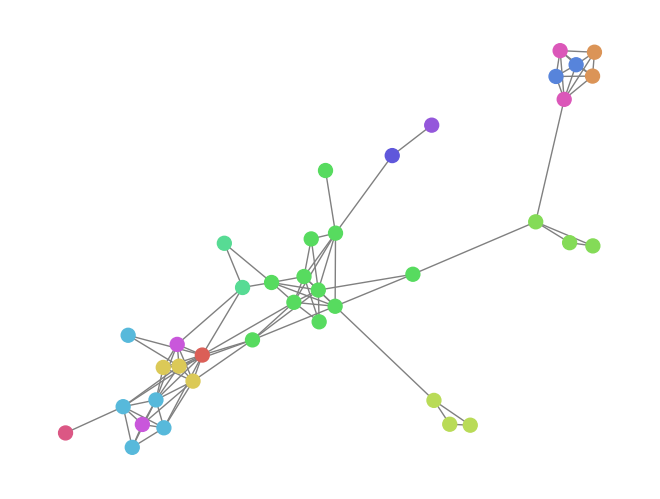

In [143]:
graph = nx.Graph()
graph.clear()

# Count the occurrences of each edge
edge_counts = {}
for edge in edges:
    key = tuple(sorted(edge))
    edge_counts[key] = edge_counts.get(key, 0) + 1

color_map = []

# Add nodes and weighted edges to the graph
for edge, count in edge_counts.items():
    node1, node2 = edge
    if count < 5:
        continue
    if not graph.has_node(node1):
        graph.add_node(node1)
        # add a color to the node
        color_map.append(author_departments[author_departments.name == node1].color.values[0])
    if not graph.has_node(node2):
        graph.add_node(node2)
        # add a color to the node
        color_map.append(author_departments[author_departments.name == node2].color.values[0])
    graph.add_edge(node1, node2, weight=count)

# display graph
nx.draw(graph, node_color=color_map, node_size=100, font_size=6.5, font_weight='bold', edge_color='gray')
plt.show()

In [41]:
counts = departments.groupby('department').agg('count').sort_values(by='id', ascending=False).head(50).sort_values(by='id', ascending=True)

In [42]:
counts


,id,published_at
department,,
Kultur-Weltweit,2459,2459
News,2682,2682
Finanzen,2795,2795
Radsport,2870,2870
Bauen-Wohnen,2871,2871
Formel-1,3000,3000
Gesundheit,3033,3033
Studium-Beruf,3152,3152
Taucha,3193,3193
